In [1]:
# 1. Thêm các thư viện cần thiết
import numpy as np 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from keras.layers import Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import time

In [2]:
# 2. Load data
train_dir = "../input/gender-classification-dataset/Training/"
test_dir = "../input/gender-classification-dataset/Validation/"

CATEGORIES = {
    0: "FeMale",
    1: "Male"
}

img_width = 64
img_height = 64
img_channel = 3

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(train_dir, target_size=(img_width, img_height),
                                                     subset='training', class_mode='binary')
val_generator = data_generator.flow_from_directory(train_dir, target_size=(img_width, img_height), 
                                                   subset='validation', class_mode='binary')
test_generator = data_generator.flow_from_directory(test_dir, target_size=(img_width, img_height), 
                                                    class_mode='binary')

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


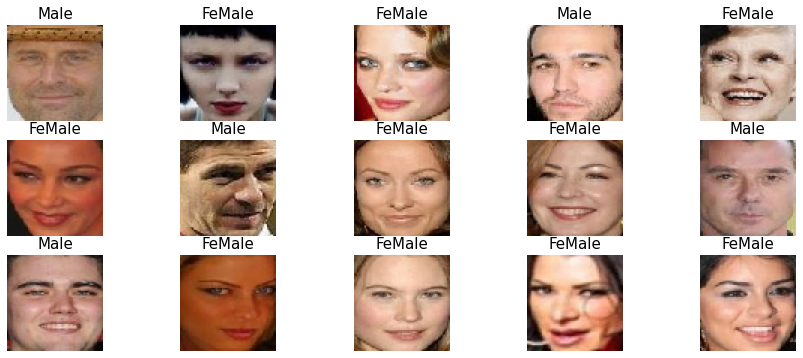

In [3]:
# 3. Show image
img, label = val_generator.next()
rows = 3
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[label[i]], fontsize=15)

In [4]:
# 4. Build model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, img_channel)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0

2022-07-14 15:46:06.819699: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# 5. Train model
start_time = time.time()

numOfEpoch = 10
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2,
                                            verbose = 1, factor = 0.5, min_lr = 0.00001)

H =  model.fit(train_generator, epochs = numOfEpoch, validation_data = val_generator, 
               verbose=1, callbacks=[earlystop,learning_rate_reduction])

end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

2022-07-14 15:46:07.199038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1176/1176 [==============================] - 187s 158ms/step - loss: 0.2878 - accuracy: 0.8782 - val_loss: 0.1603 - val_accuracy: 0.9417
Epoch 2/10
1176/1176 [==============================] - 102s 87ms/step - loss: 0.1717 - accuracy: 0.9352 - val_loss: 0.1388 - val_accuracy: 0.9502
Epoch 3/10
1176/1176 [==============================] - 99s 84ms/step - loss: 0.1526 - accuracy: 0.9444 - val_loss: 0.1608 - val_accuracy: 0.9368
Epoch 4/10
1176/1176 [==============================] - 100s 85ms/step - loss: 0.1402 - accuracy: 0.9479 - val_loss: 0.1341 - val_accuracy: 0.9493

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
1176/1176 [==============================] - 101s 86ms/step - loss: 0.1190 - accuracy: 0.9573 - val_loss: 0.0984 - val_accuracy: 0.9646
Epoch 6/10
1176/1176 [==============================] - 102s 87ms/step - loss: 0.1116 - accuracy: 0.9592 - val_loss: 0.1017 - val_accuracy: 0.9631
Epoch 7/10
1176/1176 [===============

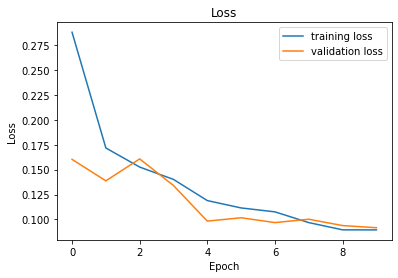

In [6]:
# 6. Vẽ đồ thị loss của traning set và validation set
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

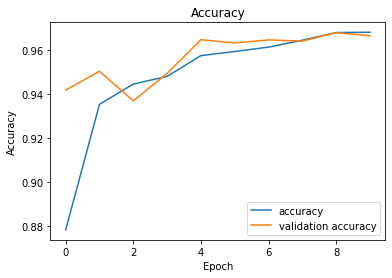

In [7]:
# 7. Vẽ đồ thị accuracy của traning set và validation set
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
# 8. Đánh giá model với testset
start_time = time.time()
print('[loss, accuracy]: ', model.evaluate(test_generator, verbose = 1))
end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

365/365 [==============================] - 48s 131ms/step - loss: 0.0874 - accuracy: 0.9689
[loss, accuracy]:  [0.08737267553806305, 0.968924343585968]
Running time: 47.73 (s)


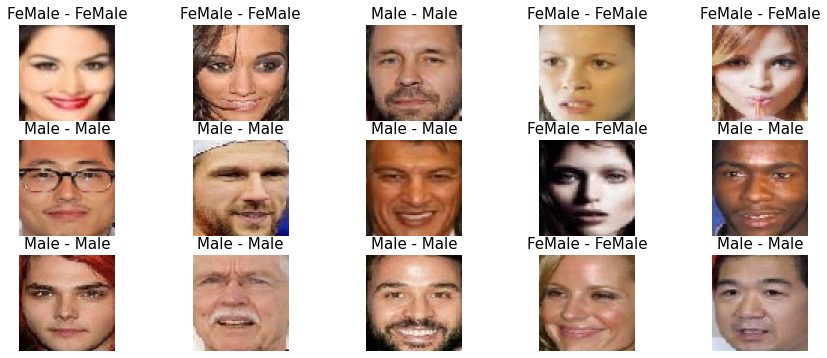

In [9]:
# 9. Show predict on tesetset
img, label = test_generator.next()
rows = 3
cols = 5

y_pred = model.predict(img[0: rows * cols])

fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    if y_pred[i] > 0.5 : y = 1
    else: y = 0
    axes[i].set_title(CATEGORIES[y] + ' - ' + CATEGORIES[label[i]], fontsize=15)

In [10]:
# 10. Save model
model.save("Gender_Classification_Model.h5")